# [Database Secret Engine](https://developer.hashicorp.com/vault/tutorials/db-credentials/database-secrets)

In [ ]:
%env  WORKDIR=/tmp/vault                 

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.0buy0tW2QcQARwJGQsEyg8Ad
%env VAULT_CACERT=/tmp/vault/vault.ca

## Step 1: Install PostgreSQL

In [ ]:
%%bash
# Add Helm repository by Bitnami
helm repo add bitnami https://charts.bitnami.com/bitnami

# Update Helm index charts
helm repo update
kubectl apply -f local-pv.yaml
kubectl apply -f pv-claim.yaml
# volumePermissions for EKS
helm install postgresql-dev -f postgres.yaml bitnami/postgresql -n vault --set volumePermissions.enabled=true

## Enable the database secret engine

In [ ]:
%%bash
export POSTGRES_URL=postgresql-dev.vault.svc.cluster.local
# Enable engine
vault secrets enable database

# Configure the database secrets engine with the connection credentials for the Postgres database.
vault write database/config/postgresql \
     plugin_name=postgresql-database-plugin \
     connection_url="postgresql://{{username}}:{{password}}@$POSTGRES_URL/postgres?sslmode=disable" \
     allowed_roles=* \
     username="postgres" \
     password="StrongPassword"


## Create a role in Vault

In [ ]:
%%bash
cat > ${WORKDIR}/readonly.sql <<EOF
CREATE ROLE "{{name}}" WITH LOGIN PASSWORD '{{password}}' VALID UNTIL '{{expiration}}' INHERIT;
GRANT ro TO "{{name}}";
EOF


In [ ]:
%%bash
vault write database/roles/readonly \
      db_name=postgresql \
      creation_statements=@${WORKDIR}/readonly.sql \
      default_ttl=1h \
      max_ttl=24h


# Demo

## Request Credentials

In [ ]:
%%bash
#via CLI
vault read database/creds/readonly

## Tambien puede hacerse en la UI: 
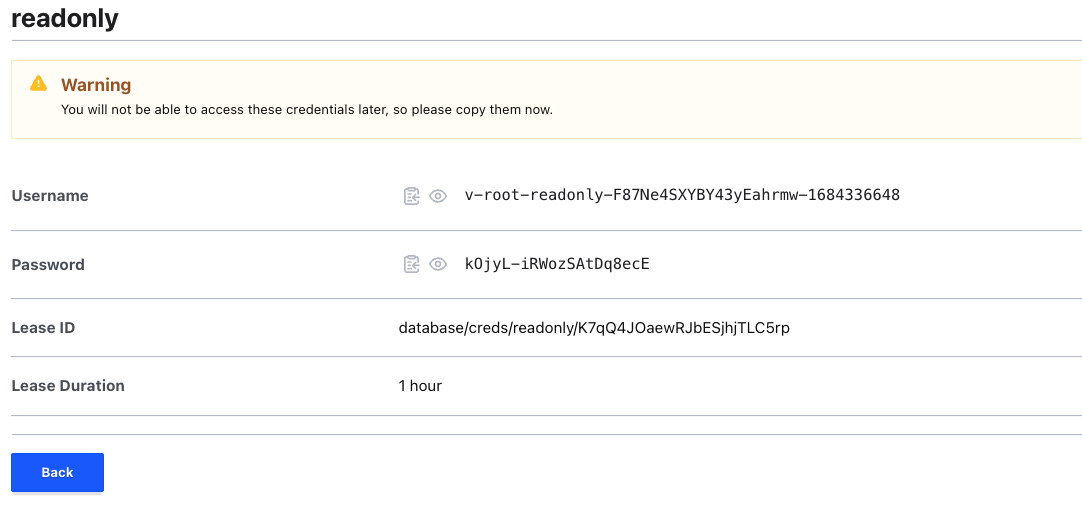

In [ ]:
%%bash
#via API
curl -k --header "X-Vault-Token: $VAULT_TOKEN" \
       --silent \
       --request GET \
       $VAULT_ADDR/v1/database/creds/readonly | jq -r .


## Revoke Credentials

In [ ]:
%%bash
## Check leases in Vault
vault list sys/leases/lookup/database/creds/readonly

In [ ]:
%%bash
## Revoke individual token
vault lease revoke database/creds/readonly/\
$(vault list -format=json sys/leases/lookup/database/creds/readonly | jq -r .[0])

In [ ]:
%%bash
## Check leases
vault list sys/leases/lookup/database/creds/readonly

In [ ]:
%%bash
## Revoke all tokens associated to a role
vault lease revoke -prefix database/creds/readonly

In [ ]:
%%bash
## Check leases
vault list -format=json sys/leases/lookup/database/creds/readonly

## Rotate Root password

In [ ]:
%%bash
vault write -force database/rotate-root/postgresql

### ¿Cómo hago para controlar el acceso de mis usuarios?

In [ ]:
%%bash

cat >  $WORKDIR/dev_policy.hcl <<EOF

path "database/*" {
  capabilities = [ "read", "list" ]
}
path "secret/*" {
  capabilities = ["list"]
}

# List Enabled secrets engine
path "sys/mounts/*" {
  capabilities = [ "list" ]
}

path "secret/data/*" {
  capabilities = ["list"]
}
path "secret/metadata/*" {
  capabilities = [ "list"]
}

path "secret/data/dev" {
  capabilities = ["list"]
}
# Can create secret on secret/dev only
path "secret/data/dev/*" {
  capabilities = ["create", "update", "read", "list"]
}
path "secret/metadata/dev/*" {
  capabilities = ["read", "create", "update", "list"]
}
 
# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}
EOF

#---

cat >  $WORKDIR/ops_policy.hcl <<EOF

# https://developer.hashicorp.com/vault/tutorials/db-credentials/database-secrets#policy-requirements
# Mount secrets engines
path "sys/mounts/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# Configure the database secrets engine and create roles
path "database/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}
path "database/roles/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# Manage the leases
path "sys/leases/+/database/creds/readonly/*" {
  capabilities = [ "create", "read", "update", "delete", "list", "sudo" ]
}

path "sys/leases/+/database/creds/readonly" {
  capabilities = [ "create", "read", "update", "delete", "list", "sudo" ]
}

# Write ACL policies
path "sys/policies/acl/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# Manage tokens for verification
path "auth/token/create" {
  capabilities = [ "create", "read", "update", "delete", "list", "sudo" ]
}

path "secret/*" {
  capabilities = ["list"]
}
# To allow a policy to delete data
path "secret/delete/*" {
  capabilities = ["update"]
}
# To allow a policy to undelete data
path "secret/undelete/*" {
  capabilities = ["update"]
}
#To allow a policy to destroy versions
path "secret/destroy/*" {
  capabilities = ["update"]
}

path "secret/data/*" {
  capabilities = ["create", "update", "read", "list", "patch"]
}
# list To allow a policy to list keys:
# read to view metada
# delete To allow a policy to permanently remove all versions and metadata for a key:
path "secret/metadata/*" {
  capabilities = ["read", "create", "update", "list", "patch", "delete"]
}

# Enable secrets engine
path "sys/mounts/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}

EOF

vault policy write dev $WORKDIR/dev_policy.hcl
vault policy write ops $WORKDIR/ops_policy.hcl


## Clean up